<div class="alert alert-block alert-warning">
Submit this notebook via Moodle!
</div>

In [1]:
import pytest
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, Dict, List

from environments.base import State, Action
from environments.normal import MABTestEnvironment
from bandits import RandomAgent, EpsilonGreedyAgent, UCBAgent, GradientBandit
from utils import experiment_factory, run_multi_seeds
from utils import plot_reward_band

# **1. Multi-Armed Bandits — Basics (8 Points)**

In this part of the exercise, you will implement several **multi-armed bandit algorithms** introduced in the lecture.  
A shared agent interface is provided in `bandits.py`, and reproduced below for convenience:

```python
class BanditAgent:
    
    def select(self, s: State) -> int:
        raise NotImplementedError

    def update(self, arm_id: int, reward: float, s: State) -> None:
        raise NotImplementedError
````

Each agent must implement two core methods:

* **`select(self, s: State) -> int`** — chooses an action given the current environment state.
  Raises a `TypeError` if `s` is not a `State`.
* **`update(self, arm_id: int, reward: float, s: State) -> None`** — updates internal statistics based on the received reward.
  Raises a `TypeError` for mismatched types and a `ValueError` if `arm_id` is not a valid action.

### Notes

* The variable `s` is an instance of `State`, which provides information about the current environment.
* `s.actions` is a list of `Action` objects; each action `a` has a unique identifier (`int`) accessible via `a.id`.
  For now, you only need the action IDs and can safely ignore other attributes.
* The **set of available actions is dynamic** — new actions may appear or disappear over time.
  Ensure that value estimates, preferences, and counters are initialized properly for any **new actions**.

`bandits.py` also contains a reference implementation of `RandomAgent`, which selects actions uniformly at random and keeps track of the available actions.

## **Task 1.1. Python Implementation (6 Points)**

Implement the `select` and `update` methods below for the following agents:

- 1.1.1. `EpsilonGreedyAgent`
- 1.1.2. `UCBAgent`
- 1.1.3. `GradientBandit`

Each class includes short documentation of the predefined member variables to guide your implementation. Use `help(ClassName)` to show the available member variables or look into the implementation in `bandits.py`.
Each agent implementation is worth **2 points**.
The sections that require your input are marked with `# TODO: YOUR CODE HERE`.

### **Important Notes**

- If an action is no longer available, **ignore it** when selecting or updating actions.  
  Only consider actions present in `s.actions`.

### **Tests**

To verify your implementation during development, run the three test cells below.  
If your implementation is correct, they should complete without any errors.

### **1.1.1. EpsilonGreedyAgent**

In [2]:
# use `help` this to show all avalable attributes; uncomment the line below...
# help(EpsilonGreedyAgent)

In [3]:


def eg_select(self, s: State) -> int:
    """Select an arm via E-greedy, initializing any new arms on the fly. Use argmax to select the greedy action; do not resolve tiebreaks via random selection."""
    if not isinstance(s, State): raise TypeError("s must be a State")
    available_ids = [a.id for a in s.actions]
    for a_id in available_ids:
        if a_id not in self.Q:
            self.Q[a_id] = self.initial_value
            self.N[a_id] = 0
    if float(self.rng.rand()) < self.epsilon:
        return int(self.rng.choice(available_ids))
    best_q = max(self.Q[a] for a in available_ids)
    for a_id in available_ids:
        if self.Q[a_id] == best_q:
            return int(a_id)


In [4]:


def eg_update(self, arm_id: int, reward: float, s: State) -> None:
    """Update Q[arm_id] from observed reward"""
    if not isinstance(arm_id, int): raise TypeError("arm id must be int")
    if not isinstance(reward, float): raise TypeError("reward id must be float")
    if not isinstance(s, State): raise TypeError("s id must be State")
    if arm_id not in self.Q or any([a.id not in self.Q for a in s.actions]) or arm_id not in [a.id for a in s.actions]:
        raise ValueError(
            f"Unseen arm {arm_id}; call `select` before `update`."
        )
    self.N[arm_id] += 1
    if self.alpha is None:
        self.Q[arm_id] += (reward - self.Q[arm_id]) / self.N[arm_id]
    else:
        self.Q[arm_id] += self.alpha * (reward - self.Q[arm_id])
    self.t += 1


In [5]:
EpsilonGreedyAgent.select = eg_select
EpsilonGreedyAgent.update = eg_update
if __name__ == '__main__':
    print("Epsilon Greedy Bandits"); print("All tests passed!" if pytest.main(["--disable-warnings", "-q", "tests/test_bandits_egreedy.py"]) == 0 else "Some tests failed.")

Epsilon Greedy Bandits
..............                                                           [100%]
14 passed in 0.03s
All tests passed!


### **1.1.2. UCBAgent**

In [6]:
# use `help` this to show all avalable attributes
# help(UCBAgent)

In [7]:


def ucb_select(self, s: State) -> int:
    """Select arm maximizing UCB index; ensure each new arm is tried once."""
    if not isinstance(s, State): raise TypeError("s must be a State")
    available_ids = [a.id for a in s.actions]
    for a_id in available_ids:
        if a_id not in self.Q:
            self.Q[a_id] = self.initial_value
            self.N[a_id] = 0
    for a_id in available_ids:
        if self.N[a_id] == 0:
            return int(a_id)
    log_term = np.log(max(self.t, 1))
    best_arm = None
    best_idx = None
    for a_id in available_ids:
        bonus = self.c * np.sqrt(log_term / self.N[a_id])
        idx = self.Q[a_id] + bonus
        if best_idx is None or idx > best_idx:
            best_idx = idx
            best_arm = a_id
    return int(best_arm)


In [8]:


def ucb_update(self, arm_id: int, reward: float, s: State) -> None:
    """Increment time, update counts, and apply sample-average value update."""
    if not isinstance(arm_id, int): raise TypeError("arm id must be int")
    if not isinstance(reward, float): raise TypeError("reward id must be float")
    if not isinstance(s, State): raise TypeError("s id must be State")
    if arm_id not in self.Q or any([a.id not in self.Q for a in s.actions]) or arm_id not in [a.id for a in s.actions]:
        raise ValueError(
            f"Unseen arm {arm_id}; call `select` before `update`."
        )
    self.t += 1
    self.N[arm_id] += 1
    self.Q[arm_id] += (reward - self.Q[arm_id]) / self.N[arm_id]


In [9]:
UCBAgent.select = ucb_select
UCBAgent.update = ucb_update
if __name__ == '__main__':
    print("UCB"); print("All tests passed!" if pytest.main(["--disable-warnings", "-q", "tests/test_bandits_ucb.py"]) == 0 else "Some tests failed.")

UCB


...........                                                              [100%]
11 passed in 0.04s
All tests passed!


### **1.1.3. GradientBandit**

In [10]:
# use `help` this to show all avalable attributes
# help(GradientBandit)

In [11]:


def gb_select(self, s: State) -> int:
    """Sample an arm according to the softmax over preferences H[a]."""
    if not isinstance(s, State): raise TypeError("s must be a State")
    available_ids = [a.id for a in s.actions]
    for a_id in available_ids:
        if a_id not in self.H:
            self.H[a_id] = 0.0
    probs = self._softmax(available_ids)
    p_vec = [probs[a_id] for a_id in available_ids]
    return int(self.rng.choice(available_ids, p=p_vec))


In [12]:


def gb_update(self, arm_id: int, reward: float, s: State) -> None:
    """Apply the preference gradient update using the current set of available arms."""
    if not isinstance(arm_id, int): raise TypeError("arm id must be int")
    if not isinstance(reward, float): raise TypeError("reward id must be float")
    if not isinstance(s, State): raise TypeError("s id must be State")
    if arm_id not in self.H or any([a.id not in self.H for a in s.actions]) or arm_id not in [a.id for a in s.actions]:
        raise ValueError(
            f"Unseen arm {arm_id}; call `select` before `update`."
        )
    available_ids = [a.id for a in s.actions]
    probs = self._softmax(available_ids)
    baseline = self.avg_reward
    for a_id in available_ids:
        indicator = 1.0 if a_id == arm_id else 0.0
        self.H[a_id] += self.alpha * (reward - baseline) * (indicator - probs[a_id])
    self.t += 1
    self.avg_reward += (reward - self.avg_reward) / self.t


In [13]:
GradientBandit.select = gb_select
GradientBandit.update = gb_update
if __name__ == '__main__':
    print("Gradient Bandits"); print("All tests passed!" if pytest.main(["--disable-warnings", "-q", "tests/test_bandits_gb.py"]) == 0 else "Some tests failed.")

Gradient Bandits
...........                                                              [100%]
11 passed in 0.03s
All tests passed!


### **Visual Sanity Check**

Once all tests pass successfully, proceed to run the cell below to perform a visual sanity check of the algorithms.

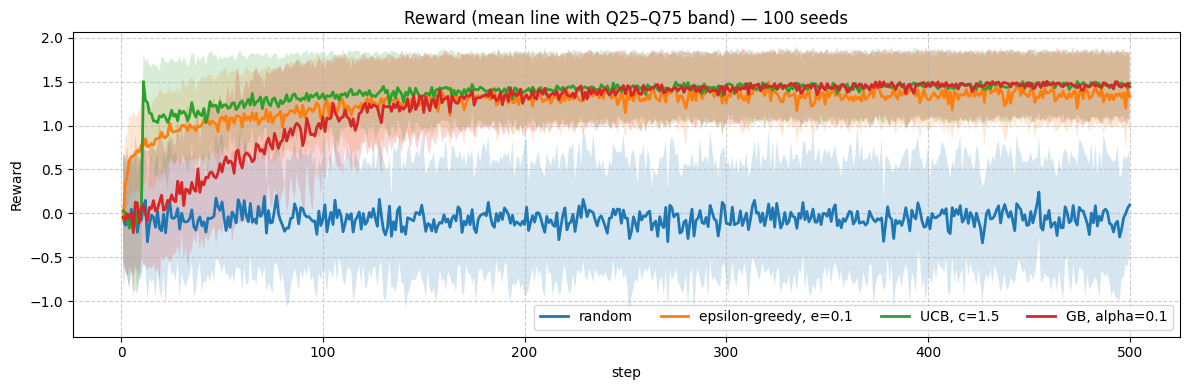

In [14]:
if __name__ == '__main__':
    # -----------------------------------------
    # reduce, if you can't afford the compute
    # -----------------------------------------
    SEEDS = np.arange(100)
    N_STEPS = 500

    # -----------------------------------------
    # initialize experiments
    # -----------------------------------------
    groups = {}

    groups["random"] = experiment_factory(
        lambda rng: RandomAgent(rng=rng),
        lambda rng: MABTestEnvironment(rng=rng)
    )

    epsilon=0.1
    groups[f"epsilon-greedy, e={epsilon}"] = experiment_factory(
        lambda rng: EpsilonGreedyAgent(rng=rng, epsilon=epsilon),
        lambda rng: MABTestEnvironment(rng=rng)
    )

    c=1.5
    groups[f"UCB, c={c}"] = experiment_factory(
        lambda rng: UCBAgent(c=c),
        lambda rng: MABTestEnvironment(rng=rng)
    )

    alpha=0.1
    groups[f"GB, alpha={alpha}"] = experiment_factory(
        lambda rng: GradientBandit(rng, alpha=alpha),
        lambda rng: MABTestEnvironment(rng=rng)
    )

    # -----------------------------------------
    # run experiments
    # -----------------------------------------
    group_stats: Dict[str, Dict[str, Any]] = {}
    for name, builder in groups.items():
        group_stats[name] = run_multi_seeds(builder, SEEDS, n_steps=N_STEPS)

    # -----------------------------------------
    # Plot: mean line + min–max band
    # -----------------------------------------
    plot_reward_band(group_stats)

## **Task 1.2. Interpretation**

**Question 1.2.1. (1 point):**  
Each epoch ends after 500 steps. Based on the results, which of the four agents performs best on average?

*Note:* Repeat the experiment with at least **50 different random seeds** to observe consistent trends.

Choose one:

1. `GB(a=0.1)` and `UCB(c=1.5)` perform equally well  
2. `GB(a=0.1)` performs best  
3. `UCB(c=1.5)` performs best

Store the index of your answer in the cell below, and briefly justify your choice in **one short sentence**.

In [15]:


best = 3


In [16]:
assert type(best) is int

UCB(c=1.5) performs best on average across the repeated runs.

**Question 1.2.2. (1 point):** 
Notice the initial reward spike of UCB followed by a drop. Explain in one or two sentences **why this happens**. Give a short textual answer below.

Would the spike become **more or less prominent** if you decreased `c` to 1? Store your answer in the variable below.

The early UCB spike comes from the optimistic exploration bonus; once estimates shrink the bonus, the average reward settles. Lowering c to 1 reduces that bonus, so the spike would be less pronounced.

In [17]:


less_prominent = True


In [18]:
assert type(less_prominent) is bool